This notebook looks at detection of a simple SN Ia model in various survey strategies.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils


We look at year=9 at most of the galactic plane etc. work is completed

In [22]:
year = 9

This is a simple SN Ia, z=0.5, stretch=1, colour=0 event from SiFTO. AB mAGS. These peak mags are in DES filters.

At z=0.5, the rise is $18d*(1+z)=27$ and we want to follow the event for about 20 days post max in the rest-frame. But we will never detect in the first few days so we just say we care about the 10 days prior to peak ie a tise of 15d observer frame.

We mock-up the rise as 2 mags over peak time, and the fall as 1.4 mags over 30 observer days in r at z=0.5

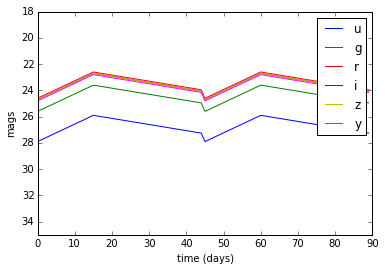

In [23]:
# Trying to make a type Ia-like 
peaks = {'uPeak':25.9, 'gPeak':23.6, 'rPeak':22.6, 'iPeak':22.7, 'zPeak':22.7,'yPeak':22.8}

colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

peakTime = 15
transDuration = peakTime+30 # Days
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30.0, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, **peaks)


times = np.arange(0.,transDuration*2,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

### What fraction are detected at least once in any filter?

In [24]:
# Pick a slicer
nside = 64
slicer = slicers.HealpixSlicer(nside=nside)
pixelArea = hp.nside2pixarea(nside, degrees=True) # in sq degrees
surveyDuration = 1. # year, since we are selection only one year in the SQL

summaryMetrics = [metrics.MedianMetric(), metrics.SumMetric()]
# Configure some metrics
metricList = []
# What fraction are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [25]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

#### NOTE - change your path and/or opsim database here

In [26]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

In [27]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint night between 3287.250000 and 3652.500000
Found 231251 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with night between 3287.250000 and 3652.500000 sqlconstraint now.
monopole: 0.599108  dipole: lon: 96.5537, lat: -36.8225, amp: 0.138778
Plotting complete.


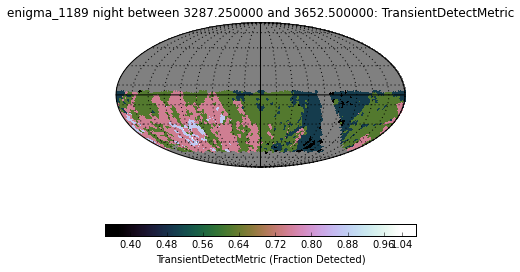

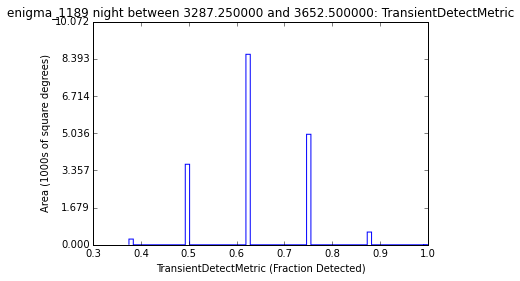

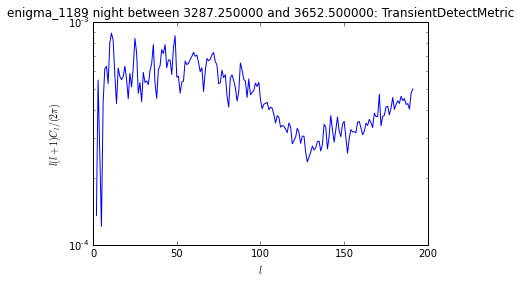

In [28]:
bgroup.plotAll(closefigs=False)

In [29]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TransientDetectMetric {'Sum': 13744.625, 'Median': 0.625}


In [30]:
# Now to try and compute the total number of SN detected
snRate = 0.1 #XXX--TOTALLY MADE UP NUMBER.  SNe/yr/sq Deg
sneN = bDict[0].summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

Total number of SN detected = 1153.577642


### What fraction are detected at least 6 times in one of g r i z, 3 in first half, 3 in second half

In [31]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [32]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000
Found 172989 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 sqlconstraint now.
monopole: 0.0914773  dipole: lon: 120.547, lat: 43.9168, amp: 0.0196547
Plotting complete.


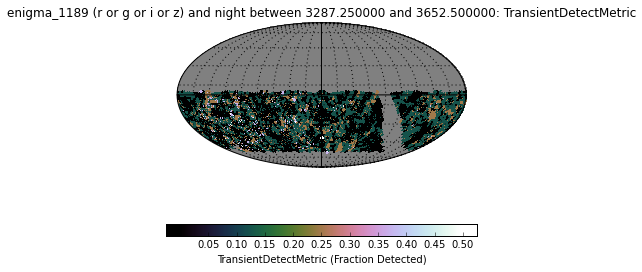

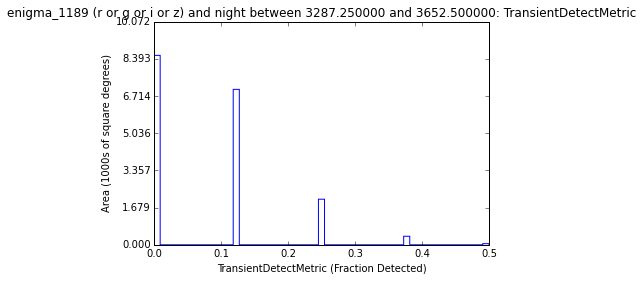

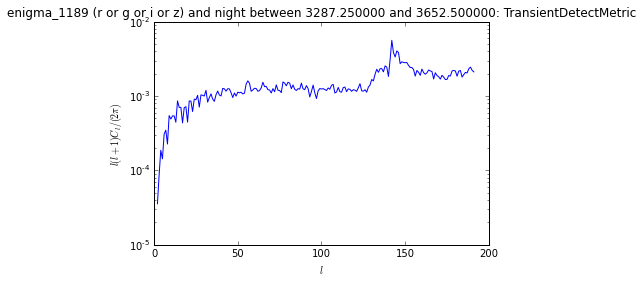

In [33]:
bgroup.plotAll(closefigs=False)

In [34]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

Total number of SN detected = 156.171565



Keywords that we need to add:

* Total number of points
* Gap time to demand between points in the same filter to count them as independent

**Let's try that again, but select only the Deep Drilling Fields**

Querying database with constraint propID = 366 and (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000
Found 7296 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with propID = 366 and (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 sqlconstraint now.
monopole: 0.375  dipole: lon: -94.7636, lat: 44.9009, amp: 1.88738e-15
Plotting complete.


Optimal bin calculation calculated NaN: returning 200
Only one metric value, making a guess at a good histogram range.


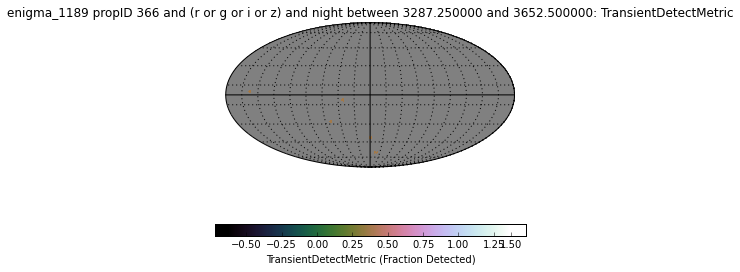

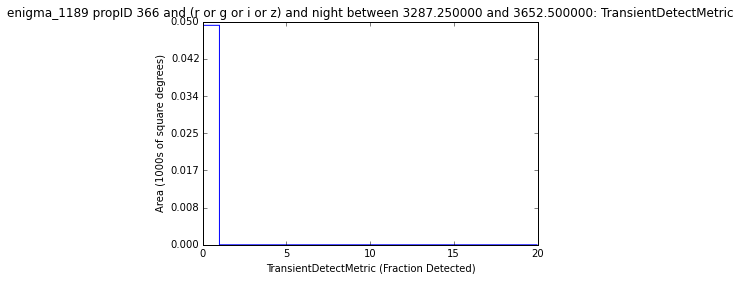

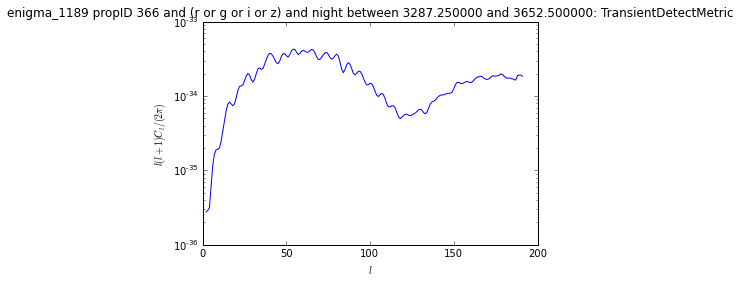

In [35]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)
propids, propTags = opsdb.fetchPropInfo()
sqlDD = utils.createSQLWhere('DD', propTags)
sqlconstraint = sqlDD+' and '+ '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [36]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

Total number of SN detected = 1.856937


### What fraction are detected at least 9 times in one of g r i z, 3 in each third

In [37]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=3, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f'% (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000
Found 172989 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 sqlconstraint now.
monopole: 0.00415465  dipole: lon: -127.741, lat: 58.8587, amp: 0.00249931
Plotting complete.


Optimal bin calculation tried to make inf bins, returning 200


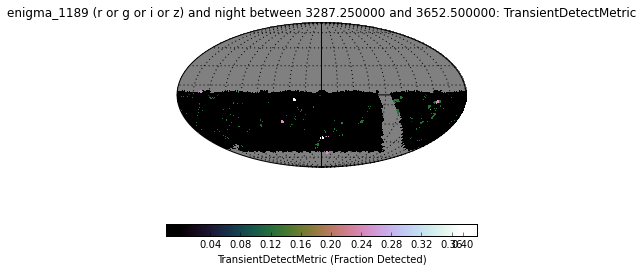

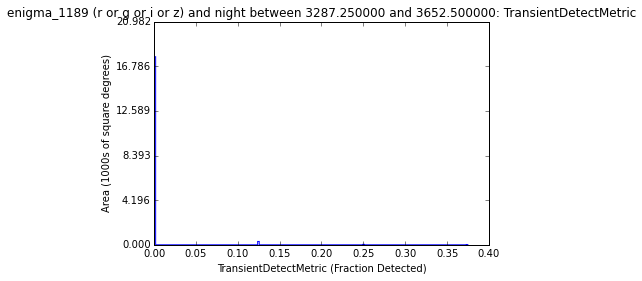

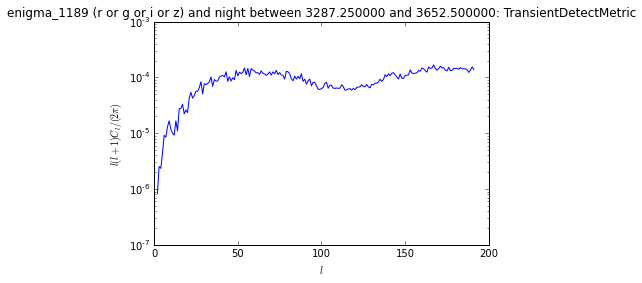

In [38]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [39]:
sneN = transBundle.summaryValues['Sum']*snRate*pixelArea*surveyDuration
print 'Total number of SN detected = %f' % sneN

Total number of SN detected = 5.812108


In [42]:
class ExtractLC(metrics.TransientMetric):
    """
    Be identical to the Transient Metric, but just save the light curves that
    meet the criteria.
    """
    def __init__(self, metricName='TransientDetectMetric', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',
                 transDuration=10.,peakTime=5., riseSlope=0., declineSlope=0.,
                 surveyDuration=10., surveyStart=None, detectM5Plus=0.,
                 uPeak=20, gPeak=20, rPeak=20, iPeak=20, zPeak=20, yPeak=20,
                 nPrePeak=0, nPerLC=1, nFilters=1, nPhaseCheck = 1,
                 **kwargs):
        super(ExtractLC,self).__init__(metricName=metricName, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol,
                                       transDuration=transDuration, peakTime=peakTime, riseSlope=riseSlope, 
                                       declineSlope=declineSlope, surveyDuration=surveyDuration, 
                                       surveyStart=surveyStart, detectM5Plus=detectM5Plus,
                     uPeak=uPeak, gPeak=gPeak, rPeak=rPeak, iPeak=iPeak, zPeak=zPeak, yPeak=yPeak,
                     nPrePeak=nPrePeak, nPerLC=nPerLC, nFilters=nFilters, nPhaseCheck = nPhaseCheck,
                     metricDtype=object,**kwargs)
        
    def run(self, dataSlice, slicePoint=None):

        # Total number of transients that could go off back-to-back
        nTransMax = np.floor(self.surveyDuration/(self.transDuration/365.25))
        tshifts = np.arange(self.nPhaseCheck)*self.transDuration/float(self.nPhaseCheck)
        nDetected = 0
        nTransMax = 0
        for tshift in tshifts:
            # Compute the total number of back-to-back transients are possible to detect
            # given the survey duration and the transient duration.
            nTransMax += np.floor(self.surveyDuration/(self.transDuration/365.25))
            if tshift != 0:
                nTransMax -= 1
            if self.surveyStart is None:
                surveyStart = dataSlice[self.mjdCol].min()
            time = (dataSlice[self.mjdCol] - surveyStart + tshift) % self.transDuration

            # Which lightcurve does each point belong to
            lcNumber = np.floor((dataSlice[self.mjdCol]-surveyStart)/self.transDuration)

            lcMags = self.lightCurve(time, dataSlice[self.filterCol])
            # How many criteria needs to be passed
            detectThresh = 0

            # Flag points that are above the SNR limit
            detected = np.zeros(dataSlice.size, dtype=int)
            detected[np.where(lcMags < dataSlice[self.m5Col] + self.detectM5Plus)] += 1
            detectThresh += 1

            # If we demand points on the rise
            if self.nPrePeak > 0:
                detectThresh += 1
                ord = np.argsort(dataSlice[self.mjdCol])
                dataSlice = dataSlice[ord]
                detected = detected[ord]
                lcNumber = lcNumber[ord]
                time = time[ord]
                ulcNumber = np.unique(lcNumber)
                left = np.searchsorted(lcNumber, ulcNumber)
                right = np.searchsorted(lcNumber, ulcNumber, side='right')
                # Note here I'm using np.searchsorted to basically do a 'group by'
                # might be clearer to use scipy.ndimage.measurements.find_objects or pandas, but
                # this numpy function is known for being efficient.
                for le,ri in zip(left,right):
                    # Number of points where there are a detection
                    good = np.where(time[le:ri] < self.peakTime)
                    nd = np.sum(detected[le:ri][good])
                    if nd >= self.nPrePeak:
                        detected[le:ri] += 1

            # Check if we need multiple points per light curve or multiple filters
            if (self.nPerLC > 1) | (self.nFilters > 1) :
                # make sure things are sorted by time
                ord = np.argsort(dataSlice[self.mjdCol])
                dataSlice = dataSlice[ord]
                detected = detected[ord]
                lcNumber = lcNumber[ord]
                ulcNumber = np.unique(lcNumber)
                left = np.searchsorted(lcNumber, ulcNumber)
                right = np.searchsorted(lcNumber, ulcNumber, side='right')
                detectThresh += self.nFilters

                for le,ri in zip(left,right):
                    points = np.where(detected[le:ri] > 0)
                    ufilters = np.unique(dataSlice[self.filterCol][le:ri][points])
                    phaseSections = np.floor(time[le:ri][points]/self.transDuration * self.nPerLC)
                    for filtName in ufilters:
                        good = np.where(dataSlice[self.filterCol][le:ri][points] == filtName)
                        if np.size(np.unique(phaseSections[good])) >= self.nPerLC:
                            detected[le:ri] += 1


        return {'lcNumber':lcNumber, 'lcMag':lcMags, 'detected':detected,
                'time':time, 'detectThresh':detectThresh, 'filter':dataSlice[self.filterCol]}


In [43]:
lcM = ExtractLC(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=3, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f and fieldRA < %f and fieldDec > %f' % (365.25*year,365.25*(year+1), np.radians(10), np.radians(-10))
transBundle = metricBundles.MetricBundle(lcM, slicer, sqlconstraint, 
                                          runName=runName)

In [44]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 and fieldRA < 0.174533 and fieldDec > -0.174533
Found 1353 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [45]:
good = np.where(transBundle.metricValues.mask == False)

array([ 23.39660024,  24.7       ,  23.37992035,  24.6109564 ,
        23.39716145,  24.6087852 ,  22.7677408 ,  23.57622574,
        23.1163816 ,  23.01235497,  23.37939386,  22.7706348 ,
        23.01144959,  23.53445627,  23.39634931,  23.53111333,
        24.032902  ,  22.97434115,  23.4147892 ,  23.77315513,
        23.76978886,  23.66107881,  23.33960656,  23.33862754,
        24.69916373,  23.77432002,  23.76872005,  25.06757813,
        23.48101147,  22.96912442,  22.96798767,  24.61327333,
        24.3097328 ,  22.87881458,  22.87971333,  24.58142293,
        24.58440427,  22.92092601,  23.39570643,  23.53683653,
        23.57991899,  23.5345536 ,  24.43647111,  24.3115884 ,
        24.19990893,  23.20171725,  23.75662335,  23.20076847,
        23.20020964,  23.57723267,  24.61591707,  23.76683555,
        24.4667136 ,  24.3141356 ,  23.80949887,  23.57897735,
        22.91982944,  22.74575653,  22.74482548,  24.0710564 ,
        23.75728149,  23.81213041,  24.66778027,  23.81

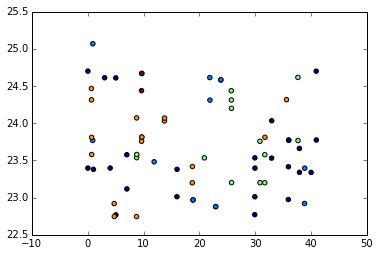

In [48]:
indx = good[0][30]
plt.scatter(transBundle.metricValues[indx]['time'], transBundle.metricValues[indx]['lcMag'], 
            c=transBundle.metricValues[indx]['lcNumber'])
transBundle.metricValues[indx]['lcMag']